## Downloading data

In [1]:
import re
import os
import glob
import zipfile
import requests
from urllib.request import urlretrieve
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

In [2]:
article_id = 14096681 
url = f"https://api.figshare.com/v2/articles/{article_id}"
headers = {"Content-Type": "application/json"}
output_directory = "figsharerainfall/"

response = requests.request("GET", url, headers=headers)
data = json.loads(response.text)
files = data["files"]
files

[{'id': 26579150,
  'name': 'daily_rainfall_2014.png',
  'size': 58863,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26579150',
  'supplied_md5': 'fd32a2ffde300a31f8d63b1825d47e5e',
  'computed_md5': 'fd32a2ffde300a31f8d63b1825d47e5e'},
 {'id': 26579171,
  'name': 'environment.yml',
  'size': 192,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26579171',
  'supplied_md5': '060b2020017eed93a1ee7dd8c65b2f34',
  'computed_md5': '060b2020017eed93a1ee7dd8c65b2f34'},
 {'id': 26586554,
  'name': 'README.md',
  'size': 5422,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26586554',
  'supplied_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c',
  'computed_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c'},
 {'id': 26766812,
  'name': 'data.zip',
  'size': 814041183,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26766812',
  'supplied_md5': 'b517383f76e77bd03755a63a8f

In [3]:
%%time
files_to_dl = ["data.zip"]
for file in files:
    if file["name"] in files_to_dl:
        os.makedirs(output_directory, exist_ok=True)
        urlretrieve(file["download_url"], output_directory + file["name"])

CPU times: user 4.76 s, sys: 3.37 s, total: 8.13 s
Wall time: 52.1 s


In [4]:
%%time
with zipfile.ZipFile(os.path.join(output_directory, "data.zip"), 'r') as f:
    f.extractall(output_directory)

CPU times: user 14.8 s, sys: 1.11 s, total: 15.9 s
Wall time: 16.1 s


## Combining CSVs

In [5]:
%%time
files = glob.glob('figsharerainfall/*.csv')
files.remove('figsharerainfall/observed_daily_rainfall_SYD.csv')

df = pd.concat((pd.read_csv(file, index_col=0)
                .assign(model=re.findall(r'[^=\\]+(?=\_daily)', file)[0].split("/")[1])
                for file in files)
              )
df.to_csv("figsharerainfall/combined_data.csv")

CPU times: user 5min 52s, sys: 9.02 s, total: 6min 1s
Wall time: 9min 35s


In [6]:
%%sh
du -sh figsharerainfall/combined_data.csv

5.6G	figsharerainfall/combined_data.csv


In [7]:
df.shape

(62467843, 6)

In [8]:
df.head()

,lat_min,lat_max,lon_min,lon_max,rain (mm/day),model
time,,,,,,
1889-01-01 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.244226e-13,MPI-ESM-1-2-HAM
1889-01-02 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.217326e-13,MPI-ESM-1-2-HAM
1889-01-03 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.498125e-13,MPI-ESM-1-2-HAM
1889-01-04 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.251282e-13,MPI-ESM-1-2-HAM
1889-01-05 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.270161e-13,MPI-ESM-1-2-HAM


#### Comparing run times:

| Team Member | Operating System | RAM | Processor | Is SSD | Time taken |
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Daniel King |  macOS 12.0.1    |16 GB|Apple M1 2020|  Yes | 5min 53s   |
| Sukhleen   |  macOS 12.3.1     |16 GB|Apple M1 2020|  Yes | 9min 35s   |
| Pavel    |   Windows 11               | 16GB    |  i7-8750H@2.2GHz        |    yes    |     18min 39s       |
| Rong   |     Windows 10             |   16GB     | i3-9100@3.60GHz    |     yes     |  6min 38s         |

## EDA in Python

### Loading the combined data into memory and performing simple EDA

In [9]:
%%time
df = pd.read_csv("figsharerainfall/combined_data.csv", index_col=0)
print(df["model"].value_counts())

MPI-ESM1-2-HR       5154240
CMCC-CM2-HR4        3541230
CMCC-ESM2           3541230
CMCC-CM2-SR5        3541230
NorESM2-MM          3541230
TaiESM1             3541230
SAM0-UNICON         3541153
GFDL-ESM4           3219300
FGOALS-f3-L         3219300
GFDL-CM4            3219300
MRI-ESM2-0          3037320
EC-Earth3-Veg-LR    3037320
BCC-CSM2-MR         3035340
MIROC6              2070900
ACCESS-CM2          1932840
ACCESS-ESM1-5       1610700
INM-CM4-8           1609650
INM-CM5-0           1609650
FGOALS-g3           1287720
KIOST-ESM           1287720
AWI-ESM-1-1-LR       966420
MPI-ESM1-2-LR        966420
NESM3                966420
MPI-ESM-1-2-HAM      966420
NorESM2-LM           919800
BCC-ESM1             551880
CanESM5              551880
Name: model, dtype: int64
CPU times: user 45.4 s, sys: 6.93 s, total: 52.3 s
Wall time: 56.1 s


#### Run times:

The combined data takes around 3.3 GB of space. Running the `.info` method, obtaining the model `.values_counts`, and getting the summary statistics of the rainfall using the `.describe` method takes the following amount of time for each group member:

| Team Member | Operating System | RAM | Processor | Is SSD | Time taken |
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Daniel King |  macOS 12.0.1    |16 GB|Apple M1 2020|  Yes |     |
| Sukhleen.   |  macOS 12.3.1    |16 GB|Apple M1 2020|  Yes | 56.1 s     |
| Pavel    |   Windows 11               | 16GB    |  i7-8750H@2.2GHz        |    yes    |     3min 1s       |
| Member 4    |                  |     |           |        |            |

In [10]:
df

,lat_min,lat_max,lon_min,lon_max,rain (mm/day),model
time,,,,,,
1889-01-01 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.244226e-13,MPI-ESM-1-2-HAM
1889-01-02 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.217326e-13,MPI-ESM-1-2-HAM
1889-01-03 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.498125e-13,MPI-ESM-1-2-HAM
1889-01-04 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.251282e-13,MPI-ESM-1-2-HAM
1889-01-05 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.270161e-13,MPI-ESM-1-2-HAM
...,...,...,...,...,...,...
2014-12-27 12:00:00,-30.157068,-29.214660,153.1250,154.3750,6.689683e+00,SAM0-UNICON
2014-12-28 12:00:00,-30.157068,-29.214660,153.1250,154.3750,7.862555e+00,SAM0-UNICON
2014-12-29 12:00:00,-30.157068,-29.214660,153.1250,154.3750,1.000503e+01,SAM0-UNICON


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62467843 entries, 1889-01-01 12:00:00 to 2014-12-31 12:00:00
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   lat_min        float64
 1   lat_max        float64
 2   lon_min        float64
 3   lon_max        float64
 4   rain (mm/day)  float64
 5   model          object 
dtypes: float64(5), object(1)
memory usage: 3.3+ GB


In [12]:
df["rain (mm/day)"].describe()

count    5.924854e+07
mean     1.901170e+00
std      5.585735e+00
min     -3.807373e-12
25%      3.838413e-06
50%      6.154947e-02
75%      1.020918e+00
max      4.329395e+02
Name: rain (mm/day), dtype: float64

## Investigating methods to reduce memory usage

### Method 1: Changing the data types of the columns

In [13]:
print(f"Memory usage with float64: {df[['lat_min','lat_max','lon_min','lon_max','rain (mm/day)']].memory_usage().sum() / 1e6:.2f} MB")
print(f"Memory usage with float32: {df[['lat_min','lat_max','lon_min','lon_max','rain (mm/day)']].astype('float32', errors='ignore').memory_usage().sum() / 1e6:.2f} MB")

Memory usage with float64: 2998.46 MB
Memory usage with float32: 1749.10 MB


> We reduce the data type of the numeric variables in the data set to `float32` to reduce the memory space that they take up. We tried using `float16`, which resulted in a much lower sys time than `float64` but for some odd reason increased the user time.

In [14]:
%%time
dtypes = {"lat_min": "float32",
          "lat_max": "float32",
          "lon_min": "float32",
          "lon_max": "float32",
          "rain (mm/day)": "float32"}

df_red_dtypes = pd.read_csv("figsharerainfall/combined_data.csv", index_col=0, dtype=dtypes)
print(df_red_dtypes["model"].value_counts())

MPI-ESM1-2-HR       5154240
CMCC-CM2-HR4        3541230
CMCC-ESM2           3541230
CMCC-CM2-SR5        3541230
NorESM2-MM          3541230
TaiESM1             3541230
SAM0-UNICON         3541153
GFDL-ESM4           3219300
FGOALS-f3-L         3219300
GFDL-CM4            3219300
MRI-ESM2-0          3037320
EC-Earth3-Veg-LR    3037320
BCC-CSM2-MR         3035340
MIROC6              2070900
ACCESS-CM2          1932840
ACCESS-ESM1-5       1610700
INM-CM4-8           1609650
INM-CM5-0           1609650
FGOALS-g3           1287720
KIOST-ESM           1287720
AWI-ESM-1-1-LR       966420
MPI-ESM1-2-LR        966420
NESM3                966420
MPI-ESM-1-2-HAM      966420
NorESM2-LM           919800
BCC-ESM1             551880
CanESM5              551880
Name: model, dtype: int64
CPU times: user 44.7 s, sys: 4.98 s, total: 49.7 s
Wall time: 52 s


#### Run times:

> After converting all of the numeric data types to `float16`, the combined data takes around 1.5 GB of space. Running the `.info` method, obtaining the model `.value_counts`, and getting the summary statistics of the rainfall using the `.describe` method takes the following amount of time for each group member:

| Team Member | Operating System | RAM | Processor | Is SSD | Time taken |
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Daniel King |  macOS 12.0.1    |16 GB|Apple M1 2020|  Yes |     |
| Sukhleen.   |  macOS 12.3.1    |16 GB|Apple M1 2020|  Yes | 52 s     |
| Pavel    |   Windows 11               | 16GB    |  i7-8750H@2.2GHz        |    yes    |     3min 7s       |
| Member 4    |                  |     |           |        |            |

In [15]:
df_red_dtypes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62467843 entries, 1889-01-01 12:00:00 to 2014-12-31 12:00:00
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   lat_min        float32
 1   lat_max        float32
 2   lon_min        float32
 3   lon_max        float32
 4   rain (mm/day)  float32
 5   model          object 
dtypes: float32(5), object(1)
memory usage: 2.1+ GB


In [16]:
df_red_dtypes["rain (mm/day)"].describe()

count    5.924854e+07
mean     1.901173e+00
std      5.585735e+00
min     -3.807373e-12
25%      3.838413e-06
50%      6.154947e-02
75%      1.020918e+00
max      4.329395e+02
Name: rain (mm/day), dtype: float64

### Method 2: Loading only selective columns - `time`, `rain (mm/day)` and `model`

Here, we load only the columns that we want to work with.

In [17]:
%%time
use_cols = ['time','rain (mm/day)', 'model']
df_subset = pd.read_csv("figsharerainfall/combined_data.csv",usecols=use_cols, index_col=0)
print(df_subset["model"].value_counts())

MPI-ESM1-2-HR       5154240
CMCC-CM2-HR4        3541230
CMCC-ESM2           3541230
CMCC-CM2-SR5        3541230
NorESM2-MM          3541230
TaiESM1             3541230
SAM0-UNICON         3541153
GFDL-ESM4           3219300
FGOALS-f3-L         3219300
GFDL-CM4            3219300
MRI-ESM2-0          3037320
EC-Earth3-Veg-LR    3037320
BCC-CSM2-MR         3035340
MIROC6              2070900
ACCESS-CM2          1932840
ACCESS-ESM1-5       1610700
INM-CM4-8           1609650
INM-CM5-0           1609650
FGOALS-g3           1287720
KIOST-ESM           1287720
AWI-ESM-1-1-LR       966420
MPI-ESM1-2-LR        966420
NESM3                966420
MPI-ESM-1-2-HAM      966420
NorESM2-LM           919800
BCC-ESM1             551880
CanESM5              551880
Name: model, dtype: int64
CPU times: user 38.4 s, sys: 4.05 s, total: 42.4 s
Wall time: 44.2 s


#### Run times:

> The memory the data set took up after only loading in the time, rainfall, and model variables was around 1.4 GB. The wall time actually increased slightly in comparison to the `float32` dataframe  even though the memory used is smaller. This is likely the case because running the describe method on the rainfall column likely negates the memory savings obtained from reducing the columns loaded in.

| Team Member | Operating System | RAM | Processor | Is SSD | Time taken |
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Daniel King |  macOS 12.0.1    |16 GB|Apple M1 2020|  Yes |       |
| Sukhleen.   |  macOS 12.3.1    |16 GB|Apple M1 2020|  Yes | 44.2 s     |
| Pavel    |   Windows 11               | 16GB    |  i7-8750H@2.2GHz        |    yes    |     2min 40s       |
| Member 4    |                  |     |           |        |            |

In [18]:
df_subset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62467843 entries, 1889-01-01 12:00:00 to 2014-12-31 12:00:00
Data columns (total 2 columns):
 #   Column         Dtype  
---  ------         -----  
 0   rain (mm/day)  float64
 1   model          object 
dtypes: float64(1), object(1)
memory usage: 1.4+ GB


In [19]:
df_subset["rain (mm/day)"].describe()

count    5.924854e+07
mean     1.901170e+00
std      5.585735e+00
min     -3.807373e-12
25%      3.838413e-06
50%      6.154947e-02
75%      1.020918e+00
max      4.329395e+02
Name: rain (mm/day), dtype: float64

### Method 3: Loading data in chunks

In [20]:
%%time
counts = pd.Series(dtype=int)
for chunk in pd.read_csv("figsharerainfall/combined_data.csv", chunksize=10_000_000):
    counts = counts.add(chunk['model'].value_counts(), fill_value=0)
print(counts.astype(int))

ACCESS-CM2          1932840
ACCESS-ESM1-5       1610700
AWI-ESM-1-1-LR       966420
BCC-CSM2-MR         3035340
BCC-ESM1             551880
CMCC-CM2-HR4        3541230
CMCC-CM2-SR5        3541230
CMCC-ESM2           3541230
CanESM5              551880
EC-Earth3-Veg-LR    3037320
FGOALS-f3-L         3219300
FGOALS-g3           1287720
GFDL-CM4            3219300
GFDL-ESM4           3219300
INM-CM4-8           1609650
INM-CM5-0           1609650
KIOST-ESM           1287720
MIROC6              2070900
MPI-ESM-1-2-HAM      966420
MPI-ESM1-2-HR       5154240
MPI-ESM1-2-LR        966420
MRI-ESM2-0          3037320
NESM3                966420
NorESM2-LM           919800
NorESM2-MM          3541230
SAM0-UNICON         3541153
TaiESM1             3541230
dtype: int64
CPU times: user 42.1 s, sys: 4.85 s, total: 47 s
Wall time: 7min 11s


#### Run times:

| Team Member | Operating System | RAM | Processor | Is SSD | Time taken |
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Daniel King |  macOS 12.0.1    |16 GB|Apple M1 2020|  Yes |     |
| Sukhleen.   |  macOS 12.3.1    |16 GB|Apple M1 2020|  Yes |   7min 11s  |
| Pavel    |   Windows 11               | 16GB    |  i7-8750H@2.2GHz        |    yes    |     2min 59s       |
| Member 4    |                  |     |           |        |            |

### Additional EDA on the original dataframe

#### Exploring grid patterns by model through spatial patterns

Remove all unnecessary columns during exploration of longitude and lattitude parameters of each model

In [21]:
dfp = df[['lat_min', 'lat_max', 'lon_min', 'lon_max', 'model']].drop_duplicates()

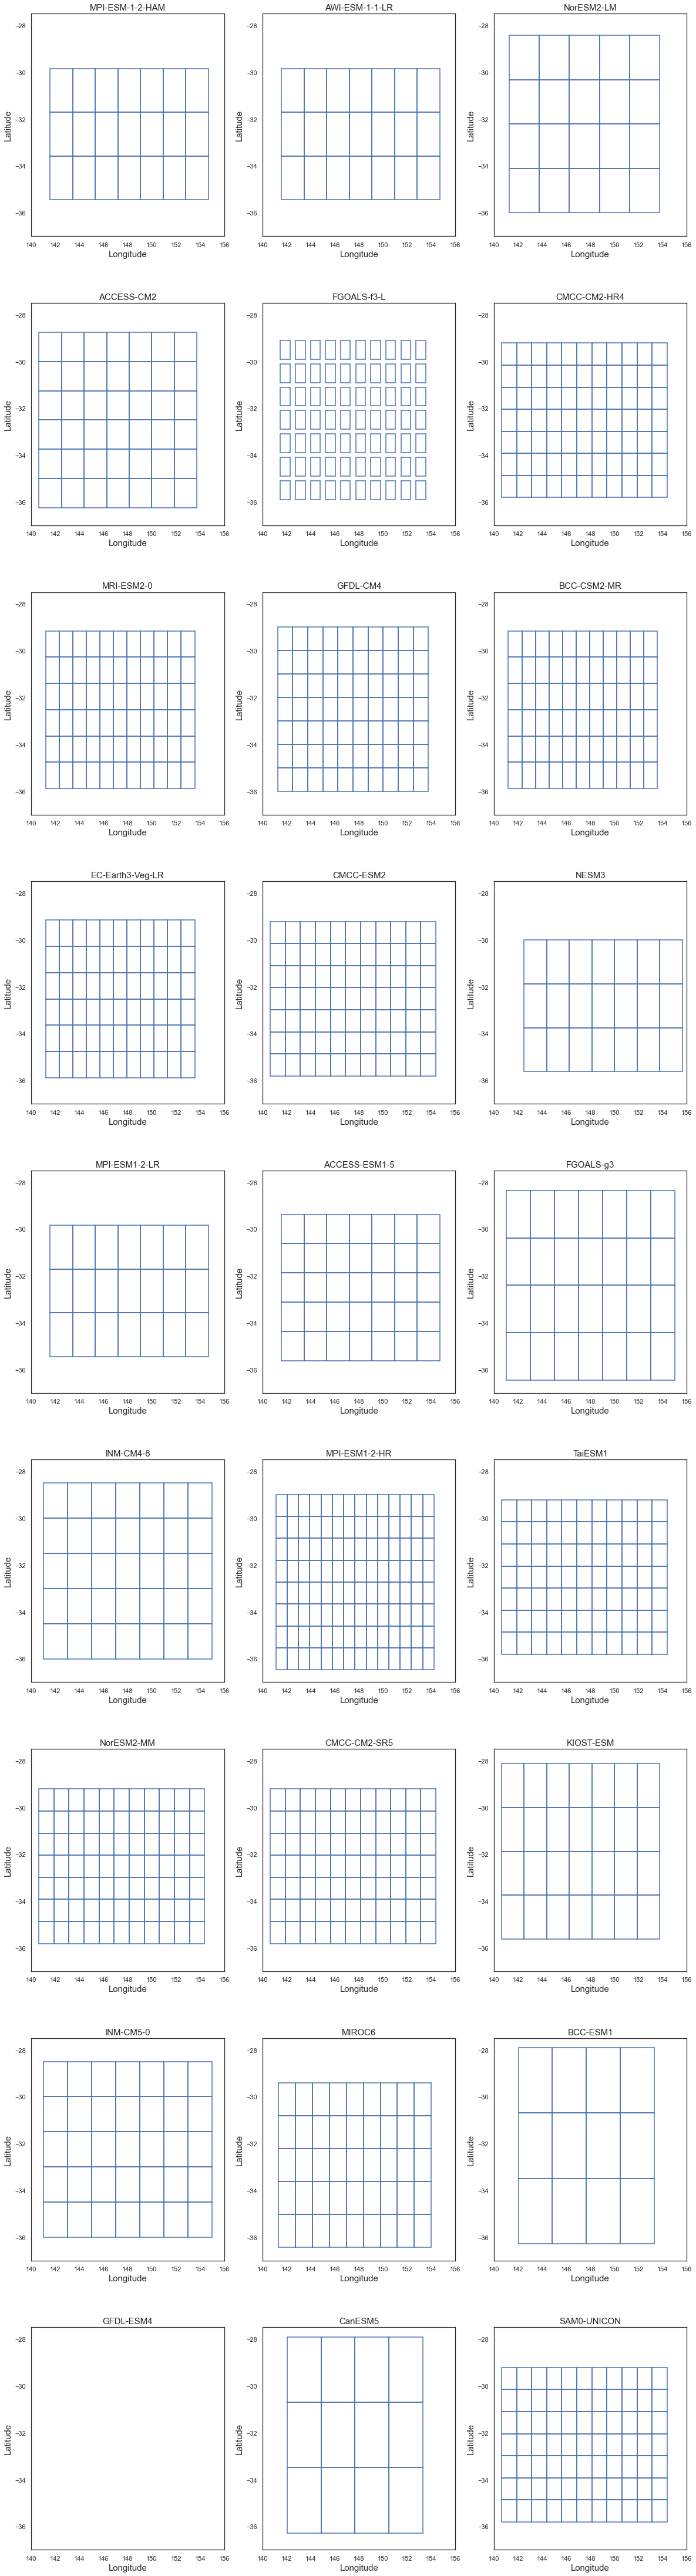

In [22]:
sns.set(rc={'figure.figsize':(20,40),"font.size":15,"axes.titlesize":15,"axes.labelsize":15},style="white") 

models = dfp["model"].unique()
num_models = len(models)

fig = plt.figure()
plt.subplots_adjust(left=None, bottom=0.5, right=None, top=2, wspace=None, hspace=0.3)
for m in range(num_models):
    model = models[m]
    plt.subplot(9, 3, m+1)
    
    dfmod = dfp[dfp['model']==model]
    for i in range(dfmod.shape[0]):
        plt.plot([dfmod['lon_min'].iloc[i], dfmod['lon_min'].iloc[i]], 
                 [dfmod['lat_min'].iloc[i], dfmod['lat_max'].iloc[i]],
                 'b') 
        plt.plot([dfmod['lon_max'].iloc[i], dfmod['lon_max'].iloc[i]], 
                 [dfmod['lat_min'].iloc[i], dfmod['lat_max'].iloc[i]], 
                'b')
        plt.plot([dfmod['lon_min'].iloc[i], dfmod['lon_max'].iloc[i]],
                 [dfmod['lat_min'].iloc[i], dfmod['lat_min'].iloc[i]], 
                'b')
        plt.plot([dfmod['lon_min'].iloc[i], dfmod['lon_max'].iloc[i]], 
                 [dfmod['lat_max'].iloc[i], dfmod['lat_max'].iloc[i]], 
                'b')
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.xlim(140, 156)
        plt.ylim(-37, -27.5)
        plt.title(model)

#### Seasonal distribution of rain amount

In order to simplify visualisations, we will lump together rain data collected during one of the months. This also alleviates some problem with outliers seen before, making plots more meaningful for comparison

In [23]:
df['log_rain'] = np.log1p(df['rain (mm/day)'])
df = df.reset_index()
df['time'] = pd.to_datetime(df['time'])
models = df['model'].unique()
num_models = len(models)
df = df.drop(columns=['lat_min', 'lat_max', 'lon_min', 'lon_max'])

columns = df.columns.to_list()
columns.append('month')
dfm = pd.DataFrame(columns = columns)

In [24]:
for model in models:
    dfmod = df[df['model']==model]
    dfmod = (dfmod.set_index('time')
               .resample('M')
               .mean()
               .reset_index()
               .assign(model = model)
              )
    dfmod['month'] = dfmod['time'].apply(lambda x: x.strftime('%B')) 
    dfm = pd.concat([dfm, dfmod]) 

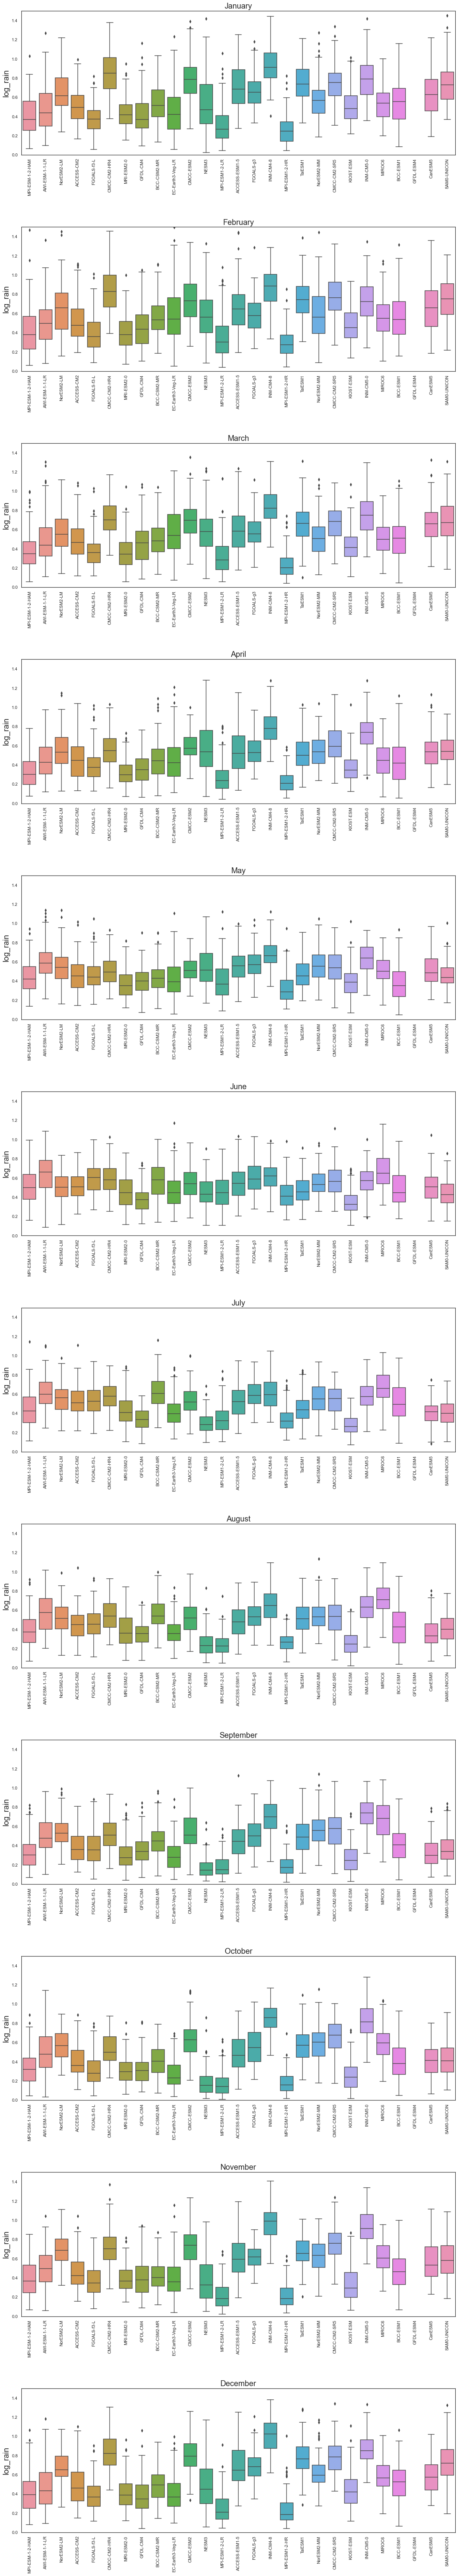

In [25]:
months = list(calendar.month_name)[1:]
num_months = len(months)
sns.set(rc={'figure.figsize':(20,60),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white") 
fig, axes = plt.subplots(num_months, 1)
plt.subplots_adjust(left=None, bottom=0.5, right=None, top=2, wspace=None, hspace=0.5)

for i in range(num_months):
    month = months[i]
    dfmon = dfm[dfm['month']==month]
    sns.boxplot(ax=axes[i], data=dfmon, x="model", y="log_rain").set_title(month) 
    axes[i].set_xlabel("")
    axes[i].set(ylim=(0, 1.5))
    axes[i].tick_params(axis='x', rotation=90);

## Performing a Simple EDA in R

The parquet and feather methods serialize from python to an intermediate file first which is then deserialized into R. However, the pandas and arrow exchange methods do the serialization and deserialization from python to R while skipping the intermediate file, saving computation time. Because we are transferring data from python to R within the same notebook it does not seem necessary to get the benefits of storing data to disk that comes with the parquet and feather methods. Arrow exchange was chosen over pandas exchange because the arrow in-memory files are a unified cross-platform format which means the serialization/deserialization process is much faster than if we used pandas exchange as pandas and R store the in-memory files in different formats. Arrow is also integrated into dplyr and offers many memory-optimized computation methods, which means the arrow format which was transferred over to R will perform much faster computations.

In [26]:
%reset -f

%load_ext rpy2.ipython

import pyarrow.dataset as ds
import pyarrow as pa
import pandas as pd
from pyarrow import csv
import rpy2_arrow.pyarrow_rarrow as pyra

pydata = ds.dataset("figsharerainfall/combined_data.csv", format="csv")
pytable = pydata.to_table()
rtable = pyra.converter.py2rpy(pytable)

In [27]:
%%R -i rtable
suppressMessages(library(dplyr))
suppressMessages(library(arrow))
rdata <- rtable

rtable <- rtable |>
    rename(rain = "rain (mm/day)")
    
rtable |> collect()

# A tibble: 62,467,843 × 7
   time                lat_min lat_max lon_min lon_max     rain model          
   <dttm>                <dbl>   <dbl>   <dbl>   <dbl>    <dbl> <chr>          
 1 1889-01-01 04:00:00   -35.4   -33.6    142.    143. 4.24e-13 MPI-ESM-1-2-HAM
 2 1889-01-02 04:00:00   -35.4   -33.6    142.    143. 4.22e-13 MPI-ESM-1-2-HAM
 3 1889-01-03 04:00:00   -35.4   -33.6    142.    143. 4.50e-13 MPI-ESM-1-2-HAM
 4 1889-01-04 04:00:00   -35.4   -33.6    142.    143. 4.25e-13 MPI-ESM-1-2-HAM
 5 1889-01-05 04:00:00   -35.4   -33.6    142.    143. 4.27e-13 MPI-ESM-1-2-HAM
 6 1889-01-06 04:00:00   -35.4   -33.6    142.    143. 4.20e-13 MPI-ESM-1-2-HAM
 7 1889-01-07 04:00:00   -35.4   -33.6    142.    143. 4.19e-13 MPI-ESM-1-2-HAM
 8 1889-01-08 04:00:00   -35.4   -33.6    142.    143. 4.56e-13 MPI-ESM-1-2-HAM
 9 1889-01-09 04:00:00   -35.4   -33.6    142.    143. 2.53e+ 0 MPI-ESM-1-2-HAM
10 1889-01-10 04:00:00   -35.4   -33.6    142.    143. 4.12e- 2 MPI-ESM-1-2-HAM
# … with 62,4

**The variable information is as follows:**

In [28]:
%%R

rtable |>  
    collect() |> 
    str()

tibble [62,467,843 × 7] (S3: tbl_df/tbl/data.frame)
 $ time   : POSIXct[1:62467843], format: "1889-01-01 04:00:00" "1889-01-02 04:00:00" ...
 $ lat_min: num [1:62467843] -35.4 -35.4 -35.4 -35.4 -35.4 ...
 $ lat_max: num [1:62467843] -33.6 -33.6 -33.6 -33.6 -33.6 ...
 $ lon_min: num [1:62467843] 142 142 142 142 142 ...
 $ lon_max: num [1:62467843] 143 143 143 143 143 ...
 $ rain   : num [1:62467843] 4.24e-13 4.22e-13 4.50e-13 4.25e-13 4.27e-13 ...
 $ model  : chr [1:62467843] "MPI-ESM-1-2-HAM" "MPI-ESM-1-2-HAM" "MPI-ESM-1-2-HAM" "MPI-ESM-1-2-HAM" ...


**Below we return the value counts for each model:**

In [29]:
%%R

rtable |> 
    count(model) |> 
    collect() |> 
    print(n=27)

# A tibble: 27 × 2
   model                  n
   <chr>              <int>
 1 MPI-ESM-1-2-HAM   966420
 2 AWI-ESM-1-1-LR    966420
 3 NorESM2-LM        919800
 4 ACCESS-CM2       1932840
 5 FGOALS-f3-L      3219300
 6 CMCC-CM2-HR4     3541230
 7 MRI-ESM2-0       3037320
 8 GFDL-CM4         3219300
 9 BCC-CSM2-MR      3035340
10 EC-Earth3-Veg-LR 3037320
11 CMCC-ESM2        3541230
12 NESM3             966420
13 MPI-ESM1-2-LR     966420
14 ACCESS-ESM1-5    1610700
15 FGOALS-g3        1287720
16 INM-CM4-8        1609650
17 MPI-ESM1-2-HR    5154240
18 TaiESM1          3541230
19 NorESM2-MM       3541230
20 CMCC-CM2-SR5     3541230
21 KIOST-ESM        1287720
22 INM-CM5-0        1609650
23 MIROC6           2070900
24 BCC-ESM1          551880
25 GFDL-ESM4        3219300
26 CanESM5           551880
27 SAM0-UNICON      3541153


**Here we obtain some summary statistics for rainfall (mm/day):**

In [30]:
%%R

rtable_rain_min <- rtable |>
    select(rain) |> 
    collect() |>
    min(na.rm = TRUE)

rtable_rain_max <- rtable |>
    select(rain) |> 
    collect() |>
    max(na.rm = TRUE)

rtable |>
    select(rain) |> 
    filter(!is.na(rain)) |> 
    summarize(
        count = n(),
        mean = round(mean(rain), 2),
        median = round(median(rain), 2),
        min = rtable_rain_min,
        first.quartile = round(quantile(rain, c(0.25)), 2),
        third.quartile = round(quantile(rain, c(0.75)), 2),
        max = rtable_rain_max
    ) |> 
    collect()

# A tibble: 1 × 7
     count  mean median       min first.quartile third.quartile   max
     <int> <dbl>  <dbl>     <dbl>          <dbl>          <dbl> <dbl>
1 59248543   1.9   0.06 -3.81e-12              0           1.03  433.


## Discussion:

**1. Discuss any challenges or difficulties you faced when dealing with this large amount of data on your laptops. Briefly explain your approach to overcome the challenges or reasons why you could not overcome them.**

The biggest challenge we faced was handling such a large data set with limited resources. There were issues with disk space and we had to delete some big files to relieve memory space during the process. During EDA, the server crashed once and we had to close other applications and restart the jupyterlab. Another problem that we encountered was with regex which ran for a long time and eventually threw an error. To overcome this, we had to try out multiple patterns on an online tool before deploying it in our notebook.